<a href="https://colab.research.google.com/github/akshayonly/ML-Antioxidant-Antibacterial-IC50/blob/main/ML_Antioxidant_Antibacterial_IC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction Of IC50 Values Of Antioxidant And Antibacterial Compounds


CONTENT

1. Packages & Libraries

2. Data Processing
  - Main Data
  - PubChem search & extracting molecular properties
  - Data with features (molecular)
  - Fingerprint processing
  - Scaling data 

3. Machine learning regression models (Dummy Model)
  - Simple Linear Regression
  - Stochastic Gradient Descent Regressors (SGDr)

4. Neural Network
  - Multi-layer Perceptron

## Packages & Libraries

In [38]:
! pip install pubchempy
! pip install biopython

In [39]:
import pandas as pd
import numpy as np
import pubchempy as pcp
import re
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

import seaborn as sns
import matplotlib.pyplot as plt 

## Data Processing

### Main Data

In [40]:
smiles_compounds = list()

with open("/content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/SMILES.txt", "r") as file:

  for lines in file:

    smile = lines.split('\t')[0].rstrip()
    comp = lines.split('\t')[1].rstrip()

    smiles_compounds.append((comp, smile))

smiles_compounds = np.array(smiles_compounds)

data = pd.DataFrame(smiles_compounds, columns=['CompName', 'SMILES'])    

In [41]:
data.head()

,CompName,SMILES
0,Apigenin-6-C-glucoside,O=C1C=C(C3=CC=C(O[H])C=C3)OC2=C1C(O[H])=C([C@@...
1,Argentinine,CN(C)CCC1=CC(O[H])=C(OC)C3=C1C=CC2=CC=CC=C23
2,Catechin,[H]OC1=C2C(O[C@@H]([C@]3=CC(O[H])=C(O[H])C=C3)...
3,Epicatechin,[H]OC1=C2C(O[C@H]([C@]3=CC(O[H])=C(O[H])C=C3)[...
4,Homoorientin,O=C1C=C(C3=CC(O[H])=C(O[H])C=C3)OC2=C1C(O[H])=...


### PubChem search & extracting molecular properties

In [42]:
def PubChemCID(SMILE):
  """
  Returns PubChem CID (ID) of given compound by SMILE
  """
  cid = pcp.get_compounds(SMILE, 'smiles')
  cid_extracted = re.findall(r'\d+', str(cid[0]))

  if len(cid_extracted)>=1:
    return cid_extracted[0]
  else:
    return str("IDENTICAL_COMPOUND_ABSENT")

In [43]:
meta_data = list()

for name, smile in tqdm(zip(data.CompName, data.SMILES)):

  pubcid = PubChemCID(smile)

  if pubcid != 'IDENTICAL_COMPOUND_ABSENT':

    compound = pcp.Compound.from_cid(pubcid)

    comp_logp = compound.xlogp

    ele_charge = compound.charge

    mol_mass = compound.exact_mass

    rotat_bond = compound.rotatable_bond_count

    iso_smile = compound.isomeric_smiles

    h_acceptor = compound.h_bond_acceptor_count

    h_donor = compound.h_bond_donor_count

    fingerprint = compound.fingerprint

    heavy_atom = compound.heavy_atom_count

    cac_fingerprint = compound.cactvs_fingerprint

    can_smile = compound.canonical_smiles

    meta_data.append((pubcid, name, heavy_atom, rotat_bond, ele_charge, 
                      mol_mass, h_donor, h_acceptor, comp_logp, 
                      can_smile, iso_smile, cac_fingerprint))
  else:
    print(pubcid, name)

23it [00:14,  1.54it/s]

IDENTICAL_COMPOUND_ABSENT Annonacin


31it [00:18,  1.64it/s]


In [44]:
column_names = ['PubChem_CID', 'CompName', 'Heavy_Atom', 'Rotat_Bond', 
                'Ele_Charge', 'Mol_Mass', 'H_Donor', 'H_Acceptor', 'XLogP', 
                'Can_SMILE', 'Iso_SMILE', 'Cac_Fingerprint']

meta_data = np.array(meta_data)

compounds_meta_data= pd.DataFrame(meta_data, columns=column_names)                        

In [45]:
compounds_meta_data["Heavy_Atom"] = compounds_meta_data["Heavy_Atom"].astype('int32')
compounds_meta_data["Rotat_Bond"] = compounds_meta_data["Rotat_Bond"].astype('int32')
compounds_meta_data["Ele_Charge"] = compounds_meta_data["Ele_Charge"].astype('float32')
compounds_meta_data["Mol_Mass"] = compounds_meta_data["Mol_Mass"].astype('float32')
compounds_meta_data["H_Donor"] = compounds_meta_data["H_Donor"].astype('int32')
compounds_meta_data["H_Acceptor"] = compounds_meta_data["H_Acceptor"].astype('int32')
compounds_meta_data["XLogP"] = compounds_meta_data["XLogP"].astype('float32')

### Data with features (molecular)

In [46]:
compounds_meta_data.head()

,PubChem_CID,CompName,Heavy_Atom,Rotat_Bond,Ele_Charge,Mol_Mass,H_Donor,H_Acceptor,XLogP,Can_SMILE,Iso_SMILE,Cac_Fingerprint
0,162350,Apigenin-6-C-glucoside,31,3,0.0,432.105652,7,10,0.2,C1=CC(=CC=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)C4C(C(...,C1=CC(=CC=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)[C@H]4...,1110000001111000001111000000000000000000000000...
1,10085878,Argentinine,22,4,0.0,295.157227,1,3,4.3,CN(C)CCC1=CC(=C(C2=C1C=CC3=CC=CC=C32)OC)O,CN(C)CCC1=CC(=C(C2=C1C=CC3=CC=CC=C32)OC)O,1110000001111010001100000000000000000000000000...
2,73160,Catechin,21,1,0.0,290.079041,5,6,0.4,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O,C1[C@H]([C@@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=...,1100000001110000001110000000000000000000000000...
3,72276,Epicatechin,21,1,0.0,290.079041,5,6,0.4,C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O,C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C...,1100000001110000001110000000000000000000000000...
4,114776,Homoorientin,32,3,0.0,448.100555,8,11,-0.2,C1=CC(=C(C=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)C4C(C...,C1=CC(=C(C=C1C2=CC(=O)C3=C(O2)C=C(C(=C3O)[C@H]...,1110000001111000001111000000000000000000000000...


In [47]:
compounds_meta_data.describe()

,Heavy_Atom,Rotat_Bond,Ele_Charge,Mol_Mass,H_Donor,H_Acceptor,XLogP
count,30.00000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,24.50000,3.666667,0.0,342.219574,4.700000,7.166667,1.270000
std,10.09182,3.546084,0.0,144.977921,3.120013,4.676304,2.835751
min,11.00000,0.000000,0.0,150.104462,0.000000,1.000000,-5.000000
25%,20.00000,1.000000,0.0,265.614197,2.250000,4.000000,-0.575000
50%,22.00000,3.000000,0.0,302.042664,4.000000,6.000000,1.050000
75%,31.00000,4.750000,0.0,431.674507,7.750000,10.750000,2.600000
max,43.00000,16.000000,0.0,610.153381,10.000000,16.000000,10.700000


In [48]:
compounds_meta_data.to_excel("compounds_molecular_properties_meta_data.xlsx", 
                             sheet_name='IC50-Missing')  

! cp -r /content/compounds_molecular_properties_meta_data.xlsx /content/drive/MyDrive/Current-Work/ML-Chemistry-Department-2021/

**DOUBT:**

1. Does ChemDraw converts structures to SMILE differently? The compounds info after search by their name has different SMILE structure from what you have given in the .txt file

### Fingerprint processing

In [49]:
fingerprint_values = np.zeros([len(compounds_meta_data), len(compounds_meta_data.Cac_Fingerprint[0])])

for idx_i, fingerprint in tqdm(enumerate(compounds_meta_data.Cac_Fingerprint)):
  for idx_j, letter in enumerate(fingerprint):
    fingerprint_values[idx_i][idx_j] = np.int(letter)

30it [00:00, 1398.02it/s]


In [50]:
column_names_finger = [f"fp{idx}" for idx in range(len(compounds_meta_data.Cac_Fingerprint[0]))]

compounds_feature_subset_2 = pd.DataFrame(fingerprint_values, columns=column_names_finger)

compounds_feature_subset_1 = compounds_meta_data[['Heavy_Atom', 'Rotat_Bond', 'H_Donor', 'H_Acceptor', 'XLogP']]

final_features = np.array(pd.concat([compounds_feature_subset_1, 
                            compounds_feature_subset_2],
                           axis=1))

In [51]:
final_features

array([[31.,  3.,  7., ...,  0.,  0.,  0.],
       [22.,  4.,  1., ...,  0.,  0.,  0.],
       [21.,  1.,  5., ...,  0.,  0.,  0.],
       ...,
       [31., 12.,  1., ...,  0.,  0.,  0.],
       [12.,  2.,  4., ...,  0.,  0.,  0.],
       [22., 16.,  4., ...,  0.,  0.,  0.]])

### Scaling data 

In [52]:
minmax = MinMaxScaler()

In [53]:
X = minmax.fit_transform(final_features)

y = np.array(compounds_meta_data['Mol_Mass']).reshape(-1, 1)
y = minmax.fit_transform(y)

In [54]:
X.shape

(30, 886)

In [55]:
y.shape

(30, 1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

## Machine learning regression models (Dummy Model)

### Simple Linear Regression

In [57]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

score = linreg.score(X_train, y_train)
print("R-squared:", score)

# cv_score = cross_val_score(lsvr, x, y, cv=5)
# print("CV mean score: ", cv_score.mean())

y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

R-squared: 1.0
MSE:  0.03017317167334852
RMSE:  0.17370426498318492


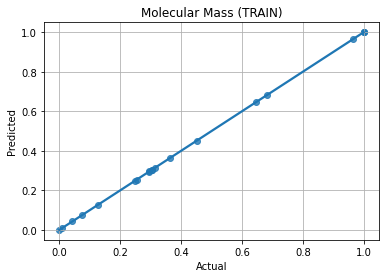

In [58]:
sns.regplot(x=y_train, y=linreg.predict(X_train))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Molecular Mass (TRAIN)')
plt.savefig('pred_act_train_molecular_mass.jpg')
plt.show()

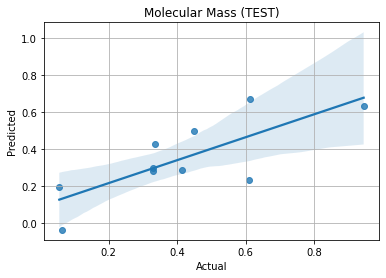

In [59]:
sns.regplot(x=y_test, y=linreg.predict(X_test))
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Molecular Mass (TEST)')
plt.savefig('pred_act_test_molecular_mass.jpg')
plt.show()

### Stochastic Gradient Descent Regressors (SGDr)


In [60]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(penalty='l1', alpha=0.001)

sgd.fit(X_train, y_train)

score = sgd.score(X_train, y_train)
print("R-squared:", score)

# cv_score = cross_val_score(lsvr, x, y, cv=5)
# print("CV mean score: ", cv_score.mean())

y_pred = sgd.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

R-squared: 0.9543599568840185


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

MSE:  0.03777353163565495
RMSE:  0.19435413974406346


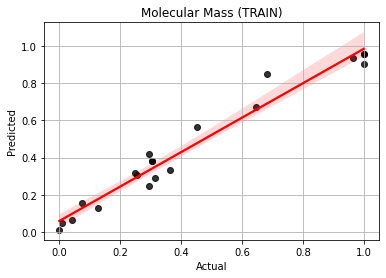

In [62]:
sns.regplot(x=y_train, y=sgd.predict(X_train), scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Molecular Mass (TRAIN)')
plt.savefig('pred_act_train_molecular_mass.jpg')
plt.show()

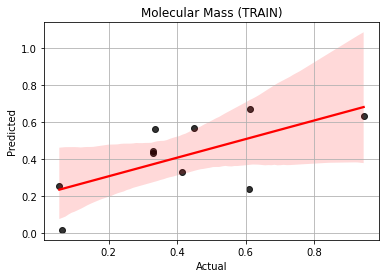

In [63]:
sns.regplot(x=y_test, y=sgd.predict(X_test), scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Molecular Mass (TEST)')
plt.savefig('pred_act_test_molecular_mass.jpg')
plt.show()